# FraudGuard - Data Exploration

**Ziel:** Dataset verstehen, Fraud-Patterns entdecken, Basis für Rules legen

## Inhalt
1. Dataset laden & inspizieren
2. Fraud-Statistiken
3. Feature-Analyse
4. Zeit-Patterns
5. Geo-Patterns
6. Erste Insights für Rules

In [21]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings

# Eigene Utils
import sys
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
from src.utils import load_data, calculate_haversine_distance, print_fraud_stats

warnings.filterwarnings('ignore')

# Plot Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Pfade definieren
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'

print("✓ Imports successful")
print(f"✓ Project root: {PROJECT_ROOT}")

✓ Imports successful
✓ Project root: C:\Users\Julian\PROJEKTE\Uni\fraudguard-project


## 1. Dataset laden

**Hinweis:** Für erste Tests nur 100k Zeilen laden (schneller!)

In [40]:
# Pfad zum Dataset
DATASET_PATH = DATA_RAW / 'fraudTrain.csv'

# Vollständig laden (1.3M rows) - dauert ~30 Sek
# df = load_data(DATASET_PATH)

# Oder: Subset für schnelles Testen (empfohlen für Entwicklung)
df = load_data(DATASET_PATH, nrows=100000)

print(f"\nShape: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loading data from C:\Users\Julian\PROJEKTE\Uni\fraudguard-project\data\raw\fraudTrain.csv...
✓ Loaded 100,000 rows, 23 columns

Shape: (100000, 23)
Memory: 79.8 MB


In [41]:
# Erste Zeilen
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [42]:
# Spaltenübersicht
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   trans_date_trans_time  100000 non-null  object 
 2   cc_num                 100000 non-null  int64  
 3   merchant               100000 non-null  object 
 4   category               100000 non-null  object 
 5   amt                    100000 non-null  float64
 6   first                  100000 non-null  object 
 7   last                   100000 non-null  object 
 8   gender                 100000 non-null  object 
 9   street                 100000 non-null  object 
 10  city                   100000 non-null  object 
 11  state                  100000 non-null  object 
 12  zip                    100000 non-null  int64  
 13  lat                    100000 non-null  float64
 14  long                   100000 non-nul

In [43]:
# Statistiken
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,49999.500000,4.183992e+17,71.908232,48720.506960,38.538809,-90.179763,8.918773e+04,1.327916e+09,38.539719,-90.180833,0.009900
std,28867.657797,1.309964e+18,145.895400,26895.490176,5.077738,13.771942,3.015788e+05,1.459296e+06,5.110508,13.783471,0.099005
min,0.000000,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.029798,-166.670132,0.000000
25%,24999.750000,1.800365e+14,9.710000,26041.000000,34.668900,-96.790900,7.430000e+02,1.326627e+09,34.750439,-96.867861,0.000000
50%,49999.500000,3.519607e+15,48.150000,48174.000000,39.354300,-87.458100,2.456000e+03,1.327877e+09,39.365135,-87.407044,0.000000
75%,74999.250000,4.642255e+15,83.870000,72011.000000,41.894800,-80.128400,2.047800e+04,1.329150e+09,41.943393,-80.180297,0.000000
max,99999.000000,4.992346e+18,12788.070000,99783.000000,65.689900,-67.950300,2.906700e+06,1.330444e+09,66.659242,-66.967742,1.000000


## 2. Fraud-Statistiken

In [44]:
# Fraud Stats ausgeben
print_fraud_stats(df)

FRAUD STATISTICS
Total Transactions: 100,000
Fraud Cases:        990
Fraud Rate:         0.99%
Legitimate Cases:   99,010


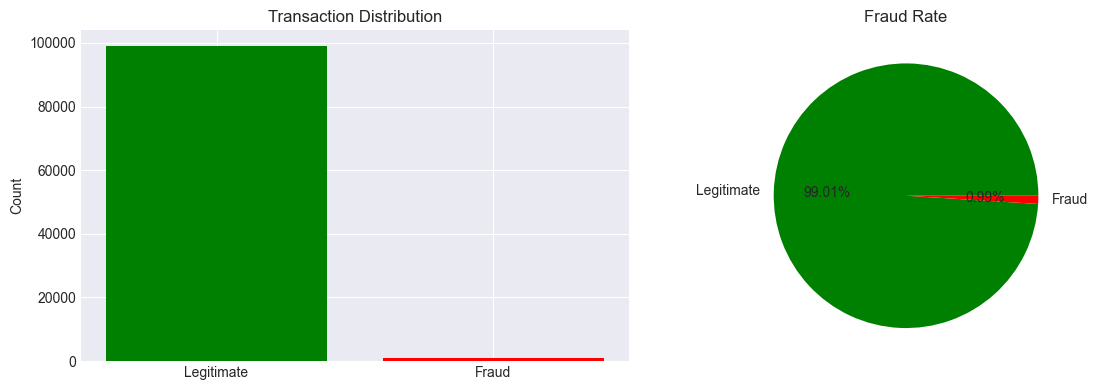

In [45]:
# Visualisierung: Fraud Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar Plot
fraud_counts = df['is_fraud'].value_counts()
axes[0].bar(['Legitimate', 'Fraud'], fraud_counts.values, color=['green', 'red'])
axes[0].set_ylabel('Count')
axes[0].set_title('Transaction Distribution')

# Pie Chart
axes[1].pie(fraud_counts.values, 
            labels=['Legitimate', 'Fraud'],
            autopct='%1.2f%%',
            colors=['green', 'red'])
axes[1].set_title('Fraud Rate')

plt.tight_layout()
plt.show()

## 3. Feature-Analyse

### 3.1 Transaction Amount

In [46]:
# Amount Statistik nach Fraud
print("Transaction Amount by Fraud Status:")
print(df.groupby('is_fraud')['amt'].describe())

Transaction Amount by Fraud Status:
            count        mean         std  min      25%      50%       75%  \
is_fraud                                                                     
0         99010.0   67.367674  133.647147  1.0    9.640   47.760   82.8700   
1           990.0  526.009939  394.454423  4.5  231.745  353.225  906.1625   

               max  
is_fraud            
0         12788.07  
1          1334.07  


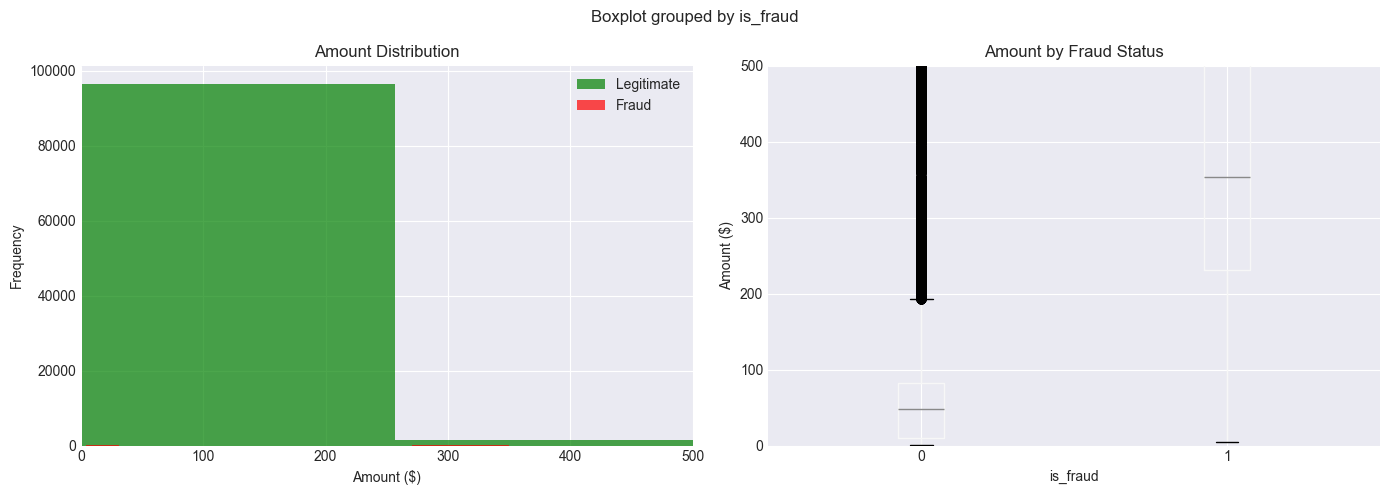

In [47]:
# Amount Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df[df['is_fraud'] == 0]['amt'], bins=50, alpha=0.7, label='Legitimate', color='green')
axes[0].hist(df[df['is_fraud'] == 1]['amt'], bins=50, alpha=0.7, label='Fraud', color='red')
axes[0].set_xlabel('Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Amount Distribution')
axes[0].legend()
axes[0].set_xlim(0, 500)  # Focus auf <500$

# Box Plot
df.boxplot(column='amt', by='is_fraud', ax=axes[1])
axes[1].set_xlabel('is_fraud')
axes[1].set_ylabel('Amount ($)')
axes[1].set_title('Amount by Fraud Status')
axes[1].set_ylim(0, 500)

plt.tight_layout()
plt.show()

### 3.2 Kategorien

In [48]:
# Fraud Rate pro Kategorie
fraud_by_category = df.groupby('category')['is_fraud'].agg(['sum', 'count', 'mean']).sort_values('mean', ascending=False)
fraud_by_category.columns = ['Fraud_Count', 'Total', 'Fraud_Rate']
fraud_by_category['Fraud_Rate'] = fraud_by_category['Fraud_Rate'] * 100  # In Prozent

print("\nFraud Rate by Category (Top 10):")
print(fraud_by_category.head(10))


Fraud Rate by Category (Top 10):
               Fraud_Count  Total  Fraud_Rate
category                                     
shopping_net           218   7596    2.869932
grocery_pos            246   9533    2.580510
misc_net               124   4931    2.514703
shopping_pos           112   9021    1.241548
gas_transport           86  10221    0.841405
travel                  19   3107    0.611522
misc_pos                31   6065    0.511129
kids_pets               37   8558    0.432344
personal_care           28   7034    0.398067
grocery_net             13   3483    0.373241


<Figure size 1200x600 with 0 Axes>

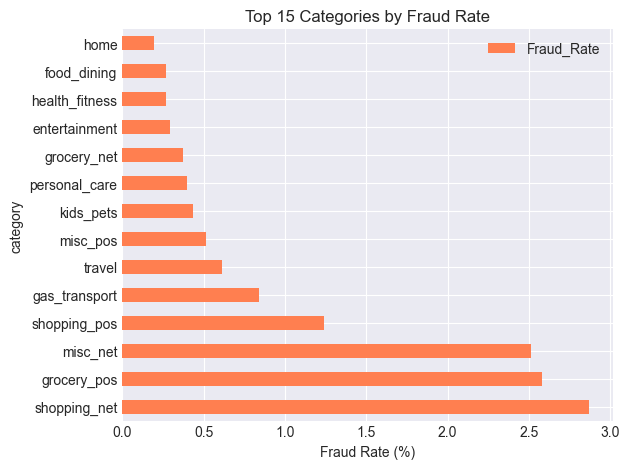

In [49]:
# Visualisierung
plt.figure(figsize=(12, 6))
fraud_by_category.head(15).plot(kind='barh', y='Fraud_Rate', color='coral')
plt.xlabel('Fraud Rate (%)')
plt.title('Top 15 Categories by Fraud Rate')
plt.tight_layout()
plt.show()

## 4. Zeit-Patterns

**Hypothese:** Fraud passiert häufiger nachts?

In [50]:
# Parse Datum/Zeit
df['trans_datetime'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_datetime'].dt.hour
df['day_of_week'] = df['trans_datetime'].dt.dayofweek  # 0=Monday
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

print("✓ Time features extracted")

✓ Time features extracted


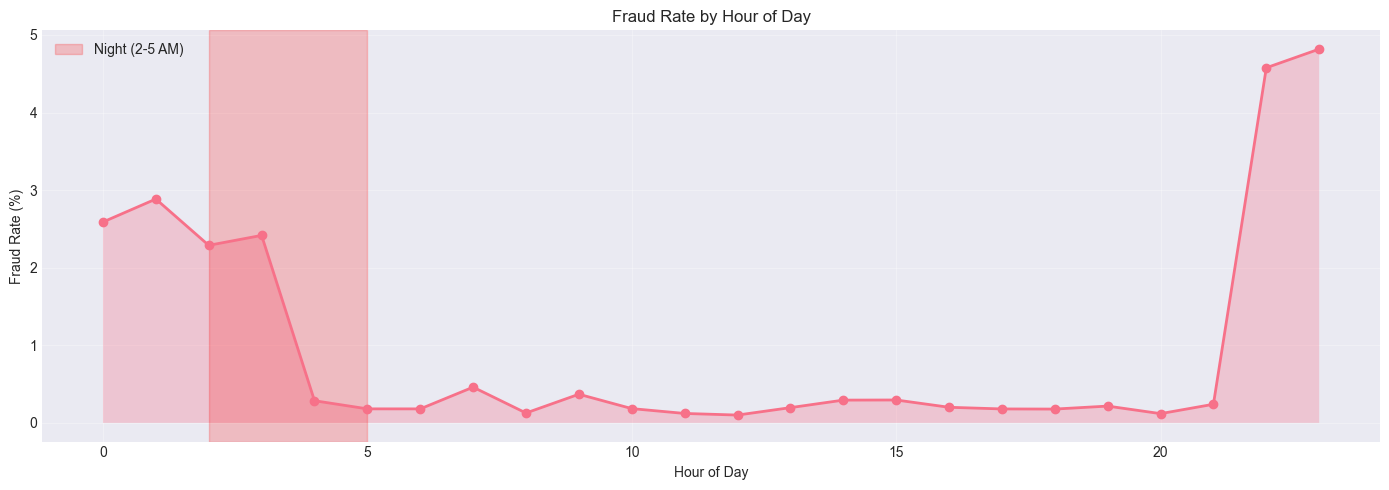


Fraud Rate by Hour:
      Fraud_Count  Total  Fraud_Rate
hour                                
0              85   3283    0.025891
1              97   3362    0.028852
2              76   3321    0.022885
3              79   3269    0.024166
4               9   3150    0.002857
5               6   3318    0.001808
6               6   3323    0.001806
7              15   3257    0.004605
8               4   3141    0.001273
9              12   3249    0.003693
10              6   3259    0.001841
11              4   3289    0.001216
12              5   4955    0.001009
13             10   5087    0.001966
14             15   5110    0.002935
15             15   5081    0.002952
16             10   4970    0.002012
17              9   5004    0.001799
18              9   5053    0.001781
19             11   5079    0.002166
20              6   5032    0.001192
21             12   4998    0.002401
22            238   5200    0.045769
23            251   5210    0.048177


In [51]:
# Fraud Rate pro Stunde
fraud_by_hour = df.groupby('hour')['is_fraud'].agg(['sum', 'count', 'mean'])
fraud_by_hour.columns = ['Fraud_Count', 'Total', 'Fraud_Rate']

plt.figure(figsize=(14, 5))
plt.plot(fraud_by_hour.index, fraud_by_hour['Fraud_Rate'] * 100, marker='o', linewidth=2)
plt.fill_between(fraud_by_hour.index, fraud_by_hour['Fraud_Rate'] * 100, alpha=0.3)
plt.axvspan(2, 5, alpha=0.2, color='red', label='Night (2-5 AM)')  # Night hours
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Hour of Day')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFraud Rate by Hour:")
print(fraud_by_hour)

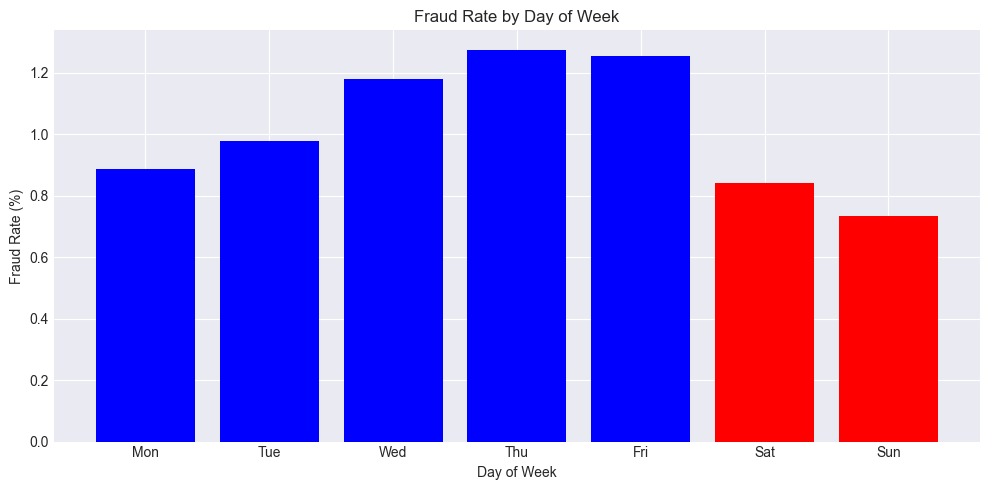

In [52]:
# Wochentag-Analyse
fraud_by_day = df.groupby('day_of_week')['is_fraud'].mean() * 100

plt.figure(figsize=(10, 5))
plt.bar(range(7), fraud_by_day.values, color=['blue']*5 + ['red']*2)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Day of Week')
plt.tight_layout()
plt.show()

## 5. Geo-Patterns

**Distance zwischen Customer und Merchant als Fraud-Indikator?**

In [53]:
# Berechne Distance (nur für Subset - dauert sonst lange!)
sample_df = df.sample(min(10000, len(df))).copy()

print("Calculating distances for sample...")
sample_df['distance_km'] = sample_df.apply(
    lambda row: calculate_haversine_distance(
        row['lat'], row['long'],
        row['merch_lat'], row['merch_long']
    ), 
    axis=1
)

print("✓ Distances calculated")

Calculating distances for sample...
✓ Distances calculated


In [54]:
# Distance Statistik
print("\nDistance Statistics by Fraud:")
print(sample_df.groupby('is_fraud')['distance_km'].describe())


Distance Statistics by Fraud:
           count       mean        std       min        25%        50%  \
is_fraud                                                                 
0         9896.0  75.911947  28.917158  1.202866  55.769845  77.909475   
1          104.0  76.594644  30.789840  5.299751  51.803798  78.314231   

                 75%         max  
is_fraud                          
0          97.894335  146.671341  
1         101.323605  135.083678  


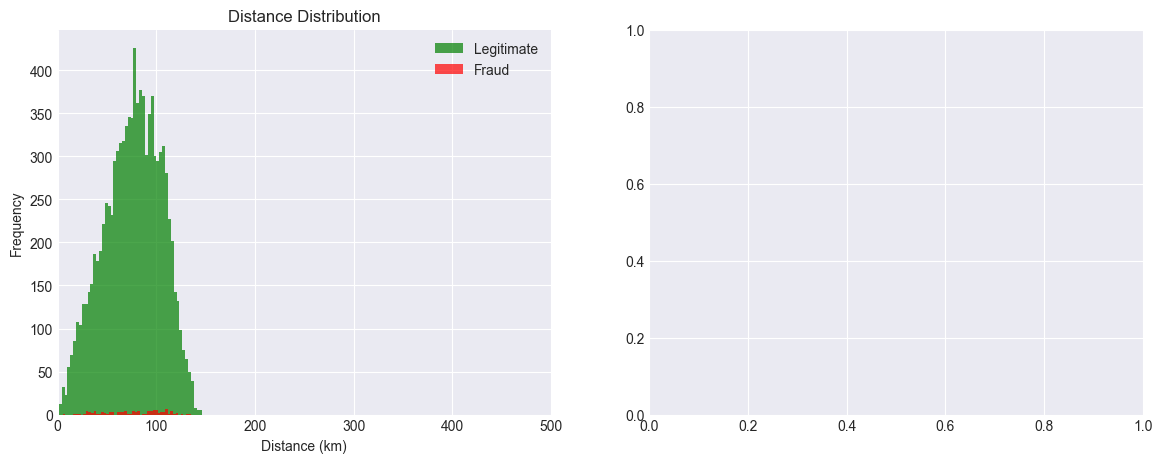

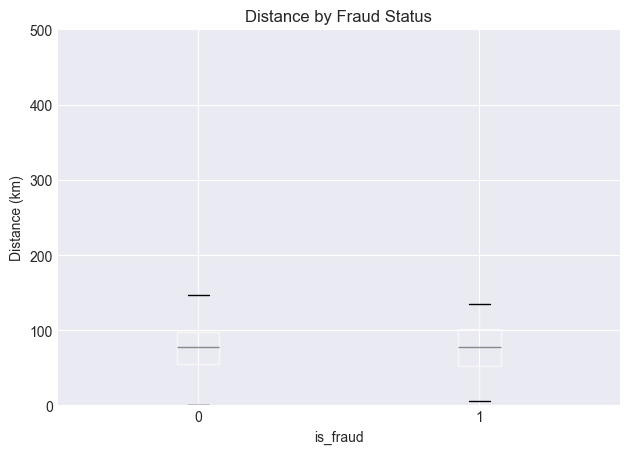

In [55]:
# Distance Distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(sample_df[sample_df['is_fraud'] == 0]['distance_km'], 
         bins=50, alpha=0.7, label='Legitimate', color='green')
plt.hist(sample_df[sample_df['is_fraud'] == 1]['distance_km'], 
         bins=50, alpha=0.7, label='Fraud', color='red')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.legend()
plt.xlim(0, 500)  # Focus

plt.subplot(1, 2, 2)
sample_df.boxplot(column='distance_km', by='is_fraud')
plt.ylabel('Distance (km)')
plt.title('Distance by Fraud Status')
plt.suptitle('')  # Remove default title
plt.ylim(0, 500)

plt.tight_layout()
plt.show()

## 6. Insights für Rule Engine

### Zusammenfassung der Patterns:

In [56]:
print("="*60)
print("KEY INSIGHTS FÜR RULES")
print("="*60)

# Amount
fraud_avg_amt = df[df['is_fraud'] == 1]['amt'].mean()
legit_avg_amt = df[df['is_fraud'] == 0]['amt'].mean()
print(f"\n1. AMOUNT")
print(f"   Fraud Avg:  ${fraud_avg_amt:.2f}")
print(f"   Legit Avg:  ${legit_avg_amt:.2f}")
print(f"   → Fraud-Transaktionen sind im Schnitt HÖHER")

# Time
night_fraud_rate = df[(df['hour'] >= 2) & (df['hour'] < 5)]['is_fraud'].mean()
day_fraud_rate = df[(df['hour'] >= 9) & (df['hour'] < 17)]['is_fraud'].mean()
print(f"\n2. TIME")
print(f"   Night (2-5 AM) Fraud Rate: {night_fraud_rate:.2%}")
print(f"   Day (9-17) Fraud Rate:     {day_fraud_rate:.2%}")
print(f"   → Nachts höheres Risiko!")

# Distance (auf Sample)
fraud_avg_dist = sample_df[sample_df['is_fraud'] == 1]['distance_km'].mean()
legit_avg_dist = sample_df[sample_df['is_fraud'] == 0]['distance_km'].mean()
print(f"\n3. DISTANCE")
print(f"   Fraud Avg Distance:  {fraud_avg_dist:.0f} km")
print(f"   Legit Avg Distance:  {legit_avg_dist:.0f} km")
print(f"   → Fraud oft weiter entfernt")

print("\n" + "="*60)
print("EMPFOHLENE RULES:")
print("="*60)
print("1. High Amount: amt > 3 * user_average")
print("2. Night Transaction: hour BETWEEN 2 AND 5")
print("3. Large Distance: distance > 100 km")
print("4. High Frequency: > 5 txns per hour")
print("5. Round Amount: amt IN [100, 500, 1000, ...]")
print("6. Out-of-State: different state than usual")
print("7. Risky Category: category in high-fraud categories")
print("="*60)

KEY INSIGHTS FÜR RULES

1. AMOUNT
   Fraud Avg:  $526.01
   Legit Avg:  $67.37
   → Fraud-Transaktionen sind im Schnitt HÖHER

2. TIME
   Night (2-5 AM) Fraud Rate: 1.68%
   Day (9-17) Fraud Rate:     0.22%
   → Nachts höheres Risiko!

3. DISTANCE
   Fraud Avg Distance:  77 km
   Legit Avg Distance:  76 km
   → Fraud oft weiter entfernt

EMPFOHLENE RULES:
1. High Amount: amt > 3 * user_average
2. Night Transaction: hour BETWEEN 2 AND 5
3. Large Distance: distance > 100 km
4. High Frequency: > 5 txns per hour
5. Round Amount: amt IN [100, 500, 1000, ...]
6. Out-of-State: different state than usual
7. Risky Category: category in high-fraud categories


## Next Steps

1. ✅ Dataset verstanden
2. ✅ Fraud-Patterns identifiziert
3. → **Nächstes Notebook:** `02_rule_analysis.ipynb` - Rule Engine implementieren und testen

In [57]:
# Optional: Speichere verarbeitete Daten für später
# output_path = DATA_PROCESSED / 'data_with_time_features.csv'
# df.to_csv(output_path, index=False)
# print(f"✓ Data saved to {output_path}")